# COMP9517 Project: Distance and Velocity Estimation

## Google Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cp "/content/drive/MyDrive/Colab Notebooks/comp9517/condensed_data.zip" "/content/"
%cp "/content/drive/MyDrive/Colab Notebooks/comp9517/mask_rcnn_coco.h5" "/content/"
%cp "/content/drive/MyDrive/Colab Notebooks/comp9517/car_mask_rcnn.h5" "/content/"
%cp -r "/content/drive/MyDrive/Colab Notebooks/comp9517/mrcnn" "/content/"
%cp -r "/content/drive/MyDrive/Colab Notebooks/comp9517/evaluate" "/content/"

In [ ]:
%cp -r "/content/benchmark_velocity_test/preds/" "/content/drive/MyDrive/Colab Notebooks/comp9517/preds/" 

cp: cannot stat '/content/benchmark_velocity_test/preds/': No such file or directory


In [ ]:
from zipfile import ZipFile

with ZipFile('/content/condensed_data.zip', 'r') as z:
  z.extractall()
  print('Done')

Done


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Imports

In [ ]:
import os
import json
import math
import random
import pickle
import cv2
import matplotlib.pyplot as plt
import numpy as np
import mrcnn.utils
import mrcnn.config
import mrcnn.model
import mrcnn.visualize

Using TensorFlow backend.


## Constants

In [ ]:
COLOR_SPACE = cv2.COLOR_BGR2RGB
TRAINING_DIR = os.path.abspath('benchmark_velocity_train/clips/')
TESTING_DIR = os.path.abspath('benchmark_velocity_test/clips/')
PRETRAINED_WEIGHTS_FILE = 'mask_rcnn_coco.h5'
WEIGHTS_FILE = 'car_mask_rcnn.h5'
CONCURRENCY_LEVEL = 1 # don't have capacity for any more
plt.rcParams['figure.figsize'] = [16, 8]

## Helper Functions

In [ ]:
# Check if two given rectangles are overlapping
def is_overlapping(a, b):
    ax1, ax2, ay1, ay2 = a
    bx1, bx2, by1, by2 = b
    
    # left side of one is after right side of other
    if ax1 >= bx2 or bx1 >= ax2:
        return False
    
    # top side of one is below bottom side of other
    if ay1 >= by2 or by1 >= ay2:
        return False
    
    return True

def calc_distance(img):
    x1, x2, y1, y2 = img
    
    ## intrinsic matrix params:
    fx = 714.1526
    fy = 710.3725
    cx = 713.85
    cy = 327

    # extrinsic data
    camera_height = 1.80
    ave_car_width = 1.80
    
    #dx2 = fy*camera_height / abs(y2-cy)
    dx = ave_car_width * fx / (x2 - x1)
    dy = dx*(x2-cx) / fx

    return [dx, dy]

def calc_velocity_across_imgs(img_a, img_b, step):
    time_per_frame = 2/40
    dist_a = calc_distance(img_a)
    dist_b = calc_distance(img_b)
    velo = [(dist_b[0] - dist_a[0]) / (step * time_per_frame),
            (dist_b[1] - dist_a[1]) / (step * time_per_frame)]
    return velo

# final bbox is detection of 40th frame
# ie detection in our program output img
velo_cache = {}
def calc_velocity(clip_num, vid_imgs, final_bbox, step):
    step=5
    global velo_cache
    if (clip_num, final_bbox) in velo_cache:
        return velo_cache[(clip_num, final_bbox)]
    if not vid_imgs:
        return [0, 0]

    vx = vy = v_count = 0
    velos = []
    for i in range(0, 40-step, step):
        start = vid_imgs[i]
        end = vid_imgs[i+step-1]
        if not (start and end):
            continue
        start_bbox, _ = get_accurate_predictions(start, [final_bbox])[0]
        end_bbox, _ = get_accurate_predictions(end, [final_bbox])[0]
        if start_bbox and end_bbox:
            v = calc_velocity_across_imgs(start_bbox, end_bbox, step-1)
            #if not ((-0.0001 <= v[0] <= 0.0001) and (-0.0001 <= v[1] <= 0.0001)):
            if (-7 < v[0] < 9) and (-1.5 < v[1] < 1.5):
                velos.append(v)
            vx += v[0]
            vy += v[1]
            v_count += 1
    
    if v_count > 0:
        vx /= v_count
        vy /= v_count
    
    velo = [0, 0]
    if velos:
        velos = sorted(velos, key=lambda x: x[0])
        #velos_y = sorted(velos, key=lambda y: y[1])[5:-5]
        #print(velos)
        velo = velos[len(velos)//2]
        velo_x = [x[0] for x in velos]
        velo_x = sum(velo_x)/len(velo_x)
        velo_y = [y[1] for y in velos]
        velo_y = sum(velo_y)/len(velo_y)
        velo = [velo_x, velo_y]
    
    velo_cache[(clip_num, final_bbox)] = velo

    return velo


## Data Parsing

In [ ]:
# retrieve feature vectors, annotations and images from
# a list of labels and data files
def parse_data(img_files, label_files, pos_data, velo_data):
    match_data, nonmatch_data, annotations, imgs, dists, velos = [], [], [], [], [], []
    if pos_data and velo_data:
        iter_data = list(zip(img_files, label_files, pos_data, velo_data))
    else:
        iter_data = list(zip(img_files, label_files))
    #random.shuffle(iter_data)

    for i, data in enumerate(iter_data):
        if pos_data:
            img_file, label_file, dists_data, velos_data = data
        else:
            img_file, label_file = data
        label = None
        if not os.path.isfile(label_file):
            continue
        with open(label_file, 'r') as f:
            label = json.load(f)
        if label is None:
            continue
            
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, COLOR_SPACE)
        imgs.append(img)
        img_annotations = []
        img_dists = []
        img_velos = []
        
        for i, label_bounds in enumerate(label):
            bbox = label_bounds['bbox']
            x1 = math.floor(bbox['left'])
            x2 = math.ceil(bbox['right'])
            y1 = math.floor(bbox['top'])
            y2 = math.ceil(bbox['bottom'])
            if pos_data:
                dist = dists_data[i]
                velo = velos_data[i]
            else:
                dist = (label_bounds['position'][0], label_bounds['position'][1])
                velo = (label_bounds['velocity'][0], label_bounds['velocity'][1])
            img_dists.append(dist)
            img_velos.append(velo)
            #calculated = calc_distance((x1,x2,y1,y2))
            #print("Gt:", dist)
            #print("Pred:", calculated)

            img_annotations.append((x1, x2, y1, y2))

        
        annotations.append(img_annotations)
        dists.append(img_dists)
        velos.append(img_velos)
    
    return (annotations, imgs, dists, velos)

def get_data(file_dir):
    img_files, label_files, pos_data, velo_data = [], [], [], []
    gt_path = os.path.join(file_dir, "..", "gt.json")
    gt_dists, gt_velos = [], []
    if os.path.isfile(gt_path):
        with open(gt_path, 'r') as f:
            gt_data = json.load(f)
            for gt in gt_data:
                gt_dists.append([(car['position'][0], car['position'][1]) for car in gt])
                gt_velos.append([(car['velocity'][0], car['velocity'][1]) for car in gt])
    for clip_num in sorted(os.listdir(file_dir), key=lambda x: int(x)):
        clip_path = os.path.join(file_dir, clip_num)
        if os.path.isdir(clip_path):
            img_files.append(os.path.join(clip_path, "imgs", "040.jpg"))
            label_files.append(os.path.join(clip_path, "annotation.json"))
            if os.path.isfile(gt_path):
                pos_data.append(gt_dists[int(clip_num)-1])
                velo_data.append(gt_velos[int(clip_num)-1])
    
    return parse_data(img_files, label_files, pos_data, velo_data)

# Get supplementary data (not used at the moment)
def get_supp_data(file_dir):
    match_data = []
    nonmatch_data = []
    annotations = []
    imgs = []
    img_files, label_file = [], os.path.join(file_dir, "annotation.json")
    with open(label_file, 'r') as f:
            label_data = json.load(f)
    

    for entry in label_data[1000:2000]:
        img_file = os.path.join(file_dir, entry['file_name'])
        if not os.path.isfile(img_file):
            continue
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, COLOR_SPACE)
        imgs.append(img)
        nonmatches = nonmatch_bounds.copy()
        
        label = entry['bbox']
        
        for label_bounds in label:
            x1 = math.floor(label_bounds['left'])
            x2 = math.ceil(label_bounds['right'])
            y1 = math.floor(label_bounds['top'])
            y2 = math.ceil(label_bounds['bottom'])
            annotations.append((x1, x2, y1, y2))
            dim_diff = (x2-x1) - (y2-y1)
            size = x2 - x1
            if x1 >= x2 or y1 >= y2:
                continue
            y1 -= math.floor(dim_diff/2)
            y2 += math.ceil(dim_diff/2)
            if y1 < 0 or y2 > img.shape[0]:
                continue
            #plt.imshow(img)
            #plt.show()
            #cv2.waitKey(0)
            match_img = img[y1:y2, x1:x2]
            match_data.append(get_features(match_img))
            nonmatches = [n for n in nonmatches if not is_overlapping(n, (x1, x2, y1, y2))]
        
        for x1, x2, y1, y2 in nonmatches:
            nonmatch_img = img[y1:y2, x1:x2]
            nonmatch_data.append(get_features(nonmatch_img))
    
    return (match_data, nonmatch_data, annotations, imgs)

## Mask R-CNN Class Definition

In [ ]:
CLASS_NAMES = ['BG', 'car']

class CarDataset(mrcnn.utils.Dataset):
    gts = []
    
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("object", 1, "car")
        img_files, label_files, pos_data = [], [], []
        self.gts = []
        if not is_train:
            gt_path = os.path.join(dataset_dir, "..", "gt.json")
            if os.path.isfile(gt_path):
                with open(gt_path, 'r') as f:
                    gt_data = json.load(f)
                    for gt in gt_data:
                        self.gts.append([(car['position'][0], car['position'][1]) for car in gt])
        for clip_num in os.listdir(dataset_dir):
            clip_path = os.path.join(dataset_dir, clip_num)
            if os.path.isdir(clip_path):
                img_path = os.path.join(clip_path, "imgs", "040.jpg")
                ann_path = os.path.join(clip_path, "annotation.json")

                self.add_image('object', image_id=clip_num, path=img_path, annotation=ann_path)

    def extract_boxes(self, image_id, ann_file):
        with open(ann_file, 'r') as f:
            annotations = json.load(f)
            
        boxes, distances = [], []
        for annotation in annotations:
            bbox = annotation['bbox']
            if self.gts:
                distance = self.gts[int(image_id)-1]
            else:
                distance = (annotation['position'][0], annotation['position'][1])
            distances.append(distance)
            x1 = math.floor(bbox['left'])
            x2 = math.ceil(bbox['right'])
            y1 = math.floor(bbox['top'])
            y2 = math.ceil(bbox['bottom'])
            boxes.append((x1, x2, y1, y2))

        width = 1280
        height = 720
        return boxes, width, height, distances

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        ann_file = info['annotation']
        boxes, w, h, distances = self.extract_boxes(image_id, ann_file)
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            x1, x2, y1, y2 = boxes[i]
            masks[y1:y2, x1:x2, i] = 1
            class_ids.append(self.class_names.index('car'))
        return masks, np.asarray(class_ids, dtype='int32')


class CarConfig(mrcnn.config.Config):
    NAME = "car_cfg"

    GPU_COUNT = 1
    IMAGES_PER_GPU = CONCURRENCY_LEVEL
    
    NUM_CLASSES = 2

    STEPS_PER_EPOCH = 131

class InferenceConfig(CarConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = CONCURRENCY_LEVEL
    #IMAGE_MIN_DIM = 512
    #IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    NUM_CLASSES = len(CLASS_NAMES)

## Mask R-CNN Training

In [ ]:
train_set = CarDataset()
train_set.load_dataset(dataset_dir=TRAINING_DIR, is_train=True)
train_set.prepare()

valid_dataset = CarDataset()
valid_dataset.load_dataset(dataset_dir=TRAINING_DIR, is_train=False)
valid_dataset.prepare()

car_config = CarConfig()

model = mrcnn.model.MaskRCNN(mode='training', 
                             model_dir='./', 
                             config=car_config)

model.load_weights(filepath=PRETRAINED_WEIGHTS_FILE, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

model.train(train_dataset=train_set, 
            val_dataset=valid_dataset, 
            learning_rate=car_config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

model.keras_model.save_weights(WEIGHTS_FILE)

## Mask R-CNN Prediction

In [ ]:
pred_model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=InferenceConfig(),
                             model_dir=os.getcwd())

pred_model.load_weights(filepath=WEIGHTS_FILE, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


## Classification & Evaluation

In [ ]:
from evaluate.velocity import VeloEval

# calculated IOU / Jaccard Index
def intersection_over_union(a, b):
    ax1, ax2, ay1, ay2 = a
    bx1, bx2, by1, by2 = b
    a_area = (ax2 - ax1) * (ay2 - ay1)
    b_area = (bx2 - bx1) * (by2 - by1)

    inter_width = min(ax2, bx2) - max(ax1, bx1)
    inter_height = min(ay2, by2) - max(ay1, by1)
    if inter_width > 0 and inter_height > 0:
        inter_area = inter_width * inter_height
    else:
        inter_area = 0
    
    union_area = a_area + b_area - inter_area
    return inter_area / union_area

def get_accurate_predictions(preds, gts):
    return [(max(preds, key=lambda p: intersection_over_union(p, gt)), gt) for gt in gts]

def calc_euclid_dist(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

# vehicle prediction evaluation
# pred: list of predicted boxes
# gt: list of ground truth boxes
def evaluate(clip_num, pred, gts, mode='tp', dists=[], velos=[]):
    # true positives
    num_detected = 0
    for gt in gts:
        num_detected += any([is_overlapping(p, gt) for p in pred])
    tp_eval = num_detected / len(gts)

    # false positives
    fp_eval = 0
    num_fp = len(pred)
    if num_fp > 0:
        for p in pred:
            num_fp -= any([is_overlapping(p, gt) for gt in gts])
        fp_eval = num_fp / len(pred)

    # jaccard index & distance evaluation
    jaccard_eval = distance_eval = velocity_eval = 0
    distance_pc_eval = velocity_pc_eval = 1
    num_detected = 0
    jaccard_sum = distance_sum = distance_pc_sum = velo_sum = velo_pc_sum = 0
    if pred:
        mappings = get_accurate_predictions(pred, gts)
        for pred, gt in mappings:
            jaccard = intersection_over_union(pred, gt)
            num_detected += 1
            jaccard_sum += jaccard
            if dists:
                gt_dist = dists[gts.index(gt)]
                pred_dist = calc_distance(pred)
                euclid_dist = calc_euclid_dist(gt_dist, pred_dist)
                distance_sum += euclid_dist
                distance_pc_sum += (euclid_dist / math.sqrt(gt_dist[0]**2 + gt_dist[1]**2))*100
                print("Gt dist:", gt_dist)
                print("Pred dist:", pred_dist)
            if velos:
                gt_velo = velos[gts.index(gt)]
                pred_velo = calc_velocity(clip_num, [], pred, 5)
                euclid_velo = calc_euclid_dist(gt_velo, pred_velo)
                velo_sum += euclid_velo
                velo_pc_sum += (euclid_velo / math.sqrt(gt_velo[0]**2 + gt_velo[1]**2))*100
                print("Gt velo:", gt_velo)
                print("Pred velo:", pred_velo)
        if num_detected > 0:
            jaccard_eval = jaccard_sum / num_detected
            distance_eval = distance_sum / num_detected
            distance_pc_eval = distance_pc_sum / num_detected
            velocity_eval = velo_sum / num_detected
            velocity_pc_eval = velo_pc_sum / num_detected

    return (tp_eval, fp_eval, jaccard_eval, distance_eval, distance_pc_eval, velocity_eval, velocity_pc_eval)

In [ ]:
# returns the RGB version of the image and a list of bounding boxes
# representing vehicle detections. Detections can be shown with show_img=True
def detect_cnn(img):
    bboxes = []
    pred = pred_model.detect([img], verbose=0)[0]
    masks = pred['masks']

    # mrcnn.visualize.display_instances(image=image, 
    #                                   boxes=pred['rois'], 
    #                                   masks=pred['masks'], 
    #                                   class_ids=pred['class_ids'], 
    #                                   class_names=CLASS_NAMES, 
    #                                   scores=pred['scores'])
    for mask in np.transpose(masks, (2, 0, 1)):
        y_vals, x_vals = np.nonzero(mask == True)
        x1 = min(x_vals)
        x2 = max(x_vals)
        y1 = min(y_vals)
        y2 = max(y_vals)
        bboxes.append((x1, x2, y1, y2))

    return bboxes

# detection_mode can be "detection_only", "velocity", or "distance"
def show_detections(img, bboxes, clip_num, mode=[], save_file=False):
    filename = f'{str(clip_num)}.jpg'

    detections = []
    if 'velocity' in mode:
        for i in range(1, 41):
            f'{str(i).zfill(3)}.jpg'
            img_file = os.path.join(TESTING_DIR, str(clip_num), 'imgs', f'{str(i).zfill(3)}.jpg')
            img = cv2.imread(img_file)
            img = cv2.cvtColor(img, COLOR_SPACE)
            detections.append(detect_cnn(img.copy()))

    img_data = []
    for bbox in bboxes:
        x1, x2, y1, y2 = bbox
        calc_dist = calc_distance(bbox)
        dist = [round(d, 2) for d in calc_dist]
        cv2.rectangle(img,(x1, y1),(x2, y2),(0,255,0),3)

        if "distance" in mode:
            label = f"pos:({dist[0]}, {dist[1]})m"
            cv2.putText(img, label, (x1, y1-15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        car = {}
        car['velocity'] = [0, 0]

        if detections:
            velo = calc_velocity(clip_num, detections, bbox, 5)
            car['velocity'] = velo
            velo[0] = round(velo[0], 2)
            velo[1] = round(velo[1], 2)
            label = f"v:({velo[0]}, {velo[1]}) m/s"
            if "distance" in mode:
                cv2.putText(img, label, (x1, y1-30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            else:
                cv2.putText(img, label, (x1, y1-15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        car['bbox'] = {'top': int(y1), 'right': int(x2), 'left': int(x1), 'bottom': int(y2)}
        car['position'] = calc_dist
        img_data.append(car)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

    if save_file:
        save_dir = os.path.join(TESTING_DIR, '..', 'preds')
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        save_file = os.path.join(save_dir, f'{str(clip_num)}.jpg')
        conv_img = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_file, conv_img)

    return img_data

# runs the detection and evaluation for each test file in the given folder
def make_predictions(data_dir, detection_mode=[], show_img=False, show_all=False, my_evaluate=False, save=False, subset=[]):
    global velo_cache
    velo_cache = {}
    pred_data = []
    distances = []
    annotations, imgs, distances, velos = get_data(data_dir)
    evaluations = []
    for i, (img, gts) in enumerate(list(zip(imgs, annotations))):
        if subset and (i+1) not in subset:
            continue
        #if i < 228:
        #    continue
        bboxes = detect_cnn(img.copy())
        to_show = bboxes
        if show_img:
            # only show expected detections
            if not show_all and bboxes:
                to_show = get_accurate_predictions(bboxes, gts)
                to_show = [x[0] for x in to_show]
            img_pred_data = show_detections(img.copy(), to_show, i+1, detection_mode, save_file=True)
            pred_data.append(img_pred_data)

        if my_evaluate:
            evaluation = evaluate(i+1, bboxes, gts, mode='all', dists=distances[i], velos=velos[i])
            print("True Positive:", evaluation[0])
            print("False Positive:", evaluation[1])
            print("Jaccard Index:", evaluation[2])
            print("Distance Error (m):", evaluation[3])
            print("Distance Error (%):", evaluation[4])
            print("Velocity Error (m/s):", evaluation[5])
            print("Velocity Error (%):", evaluation[6])
            evaluations.append(evaluation)
    if my_evaluate:
        print("\n")
        print("True Positives Average:", sum([e[0] for e in evaluations]) / len(evaluations))
        print("False Positives Average:", sum([e[1] for e in evaluations]) / len(evaluations))
        print("Jaccard Index Average:", sum([e[2] for e in evaluations]) / len(evaluations))
        print("Distance Error Average (m):", sum([e[3] for e in evaluations]) / len(evaluations))
        print("Distance Error Average (%):", sum([e[4] for e in evaluations]) / len(evaluations))
        print("Velocity Error Average (m/s):", sum([e[5] for e in evaluations]) / len(evaluations))
        print("Velocity Error Average (%):", sum([e[6] for e in evaluations]) / len(evaluations))
    
    if save:
        with open(os.path.join(TESTING_DIR, '..', 'pred.json'), 'w+') as f:
            json.dump(pred_data, f)
    return pred_data


In [ ]:
preds = make_predictions(TESTING_DIR, detection_mode=["distance", "velocity"], show_img=True, show_all=False, my_evaluate=True, save=True)

In [ ]:
VeloEval.bench_one_submit(os.path.join(TESTING_DIR, '..', 'pred.json'), os.path.join(TESTING_DIR, '..', 'gt.json'))

## Demo Run

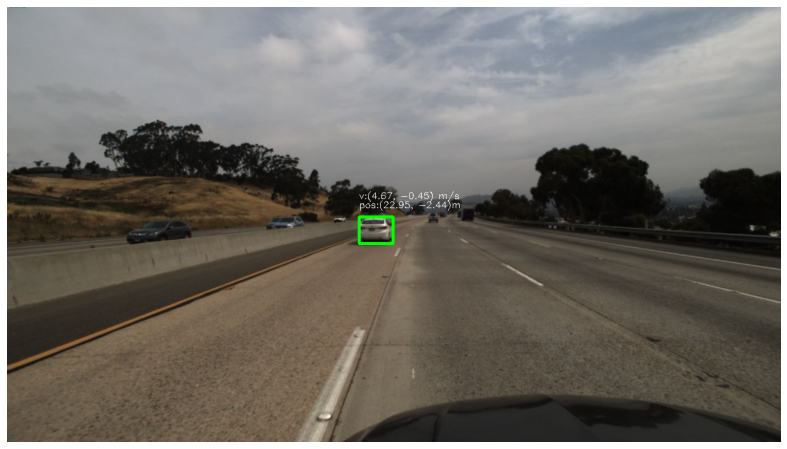

Gt dist: (23.1041825728, -2.4798558511)
Pred dist: [22.954905, -2.4380357142857148]
Gt velo: (4.7997530531, -0.6400653604)
Pred velo: [4.67, -0.45]
True Positive: 1.0
False Positive: 0.75
Jaccard Index: 0.8514851485148515
Distance Error (m): 0.15502489343400486
Distance Error (%): 0.6671499954803829
Velocity Error (m/s): 0.23013191002716957
Velocity Error (%): 4.752589467499977


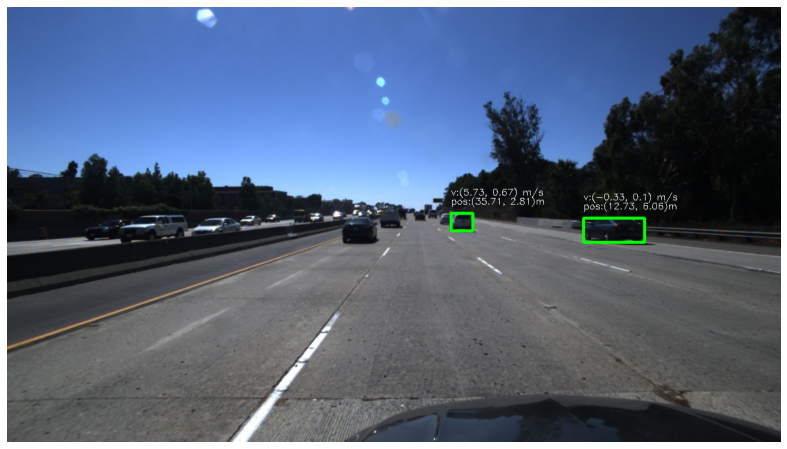

Gt dist: (39.4494299541, 2.5221968311)
Pred dist: [35.70763, 2.8074999999999988]
Gt velo: (-2.189476101, 0.231812005)
Pred velo: [5.73, 0.67]
Gt dist: (22.9659264205, 9.6340210706)
Pred dist: [12.72747207920792, 6.062079207920792]
Gt velo: (-0.8490657347, -0.0170020839)
Pred velo: [-0.33, 0.1]
True Positive: 1.0
False Positive: 0.6666666666666666
Jaccard Index: 0.8386646614125439
Distance Error (m): 7.298154837498843
Distance Error (%): 26.516816142515907
Velocity Error (m/s): 4.231839210432421
Velocity Error (%): 211.45061688172657


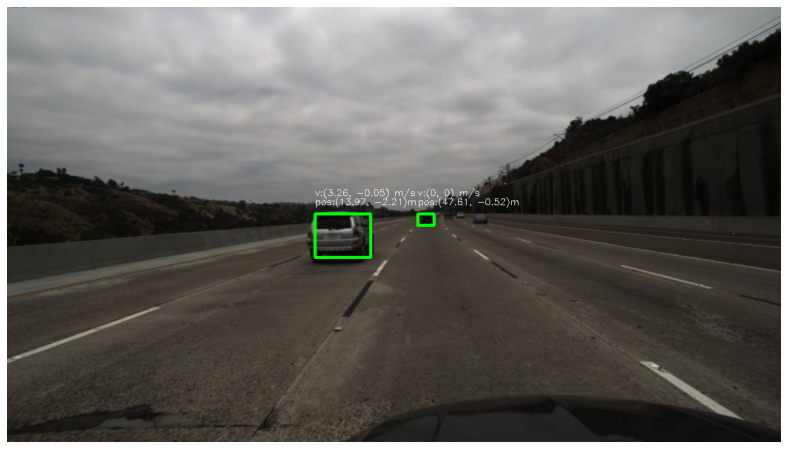

Gt dist: (60.1671414563, -0.0850252832)
Pred dist: [47.610173333333336, -0.5233333333333349]
Gt velo: (4.8467660514, -0.2098828819)
Pred velo: [0, 0]
Gt dist: (64.5922088524, 9.0877781267)
Pred dist: [13.972550869565218, -2.207934782608696]
Gt velo: (3.340509701, 0.9171419997)
Pred velo: [3.26, -0.05]
True Positive: 0.5
False Positive: 0.5
Jaccard Index: 0.3064516129032258
Distance Error (m): 32.214637491532336
Distance Error (%): 50.19762472816635
Velocity Error (m/s): 2.9108977515604697
Velocity Error (%): 64.00768637691192


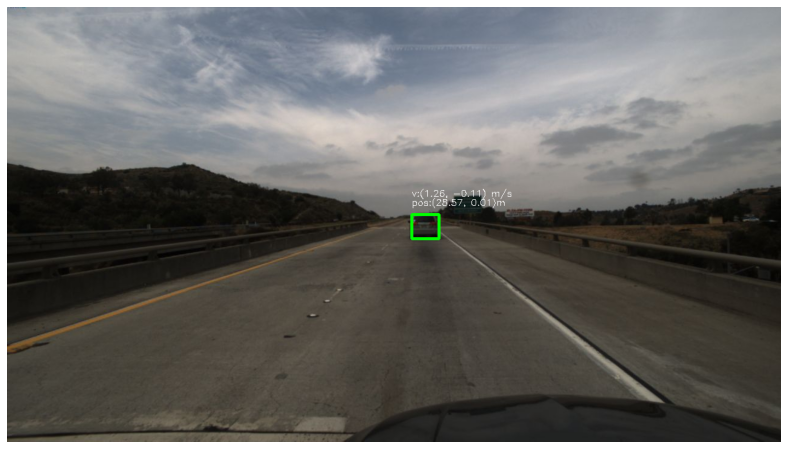

Gt dist: (27.2462639461, -0.3567028158)
Pred dist: [28.566104, 0.00599999999999909]
Gt velo: (0.1091368012, 0.1108480743)
Pred velo: [1.26, -0.11]
True Positive: 1.0
False Positive: 0.0
Jaccard Index: 0.8241758241758241
Distance Error (m): 1.3687699224004006
Distance Error (%): 5.023267189041729
Velocity Error (m/s): 1.1718617556154765
Velocity Error (%): 753.3302655724727


True Positives Average: 0.875
False Positives Average: 0.47916666666666663
Jaccard Index Average: 0.7051943117516113
Distance Error Average (m): 10.259146786216396
Distance Error Average (%): 20.601214513801093
Velocity Error Average (m/s): 2.136182656908884
Velocity Error Average (%): 258.3852895746528


In [ ]:
preds = make_predictions(TESTING_DIR, detection_mode=["distance", "velocity"], show_img=True, show_all=False, my_evaluate=True, save=True, subset=[10, 43, 44, 83])